In [1]:
#########################################################################################
##
## Refined Pseudo Label Generating
##
## I use the UNet-Xception network trained on pseudo label to generate liekhood maps
## The I use SVR to learn foreground/background segmentation on each image
## The SVR is then used to assign each pixel with a likehood score
## The new likehood map is used as seed for GrabCut algorithm to make the segmentation masks
## We use the refined masks as refined-pseudo labels
##
## Author:  Peizhi Yan
##   Date:  Apr. 8, 2021
##
#########################################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

from sklearn.cluster import KMeans

import model.unet_xception as unet_xception 
import model.icassp as icassp
import model.icassp_multiscale as icassp_multiscale
import model.autoencoder as autoencoder 

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator

import evaluation

import loss


W0408 20:47:20.603399 12532 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
"""Compute average deep feature vectors for each segment in training dataset"""
keras.backend.clear_session()
tf.reset_default_graph()

# Load training images
list_ids = []
for fname in os.listdir('./data/224x224/train'):
    if fname.startswith('_') == False and fname.endswith('.jpg'):
        list_ids.append(fname[:-4])        
train_x, train_y = pet.load_data(data_path='./data/224x224/train', 
                                 list_ids=list_ids, width=224, height=224, 
                                 standardization=False)
train_y = None; del train_y # remove train_y to save memory


EXPERIMENT_NAME = 'pseudo_label__aug-True_iter-0' # initial training iteration
#""" Load model """
model = unet_xception.get_model(img_size=(224,224), num_classes=1)
model.load_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

In [14]:
def vector_generator(img, lmap, window_size=10, stride=5):
    """
    Use a sliding window to get the mean RGB value vectors 
    with likehood for foreground and background
    """
    vectors = [] # store the mean RGB vectors
    likehoods = [] # store the mean like hood values
    H, W = img.shape[0], img.shape[1]
    i = 0
    while i + window_size <= H:
        j = 0
        while j + window_size <= W:
            img_patch = img[i:i+window_size, j:j+window_size, :]
            map_patch = lmap[i:i+window_size, j:j+window_size, 0]
            rgb = [np.mean(img_patch[:,:,0]),
                   np.mean(img_patch[:,:,1]),
                   np.mean(img_patch[:,:,2])]
            vectors.append(rgb)
            likehoods.append(np.mean(map_patch))
            j += stride
        i += stride
    return np.array(vectors), np.array(likehoods)

In [15]:
"""use model trained on pseudo labels to generate likehood maps"""
likehood_maps = model.predict(train_x) # likehood map

idx  0


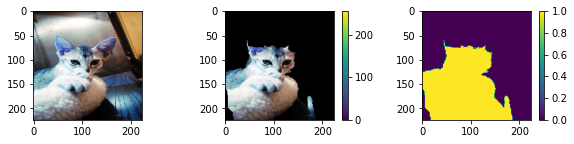

idx  10


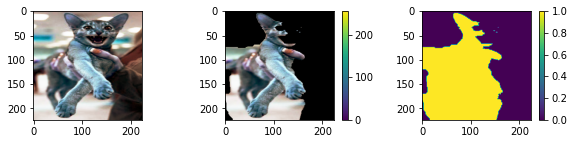

idx  20


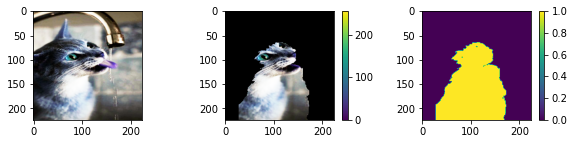

KeyboardInterrupt: 

In [19]:
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

"""Generate Refined Pseudo Labels"""
for idx in range(len(list_ids)):
    ###################################################
    ## Generate mean vectors for training SVR 
    X, Y = vector_generator(train_x[idx], likehood_maps[idx], window_size=10, stride=5)
    svr = SVR(C=1.0, epsilon=0.2)
    svr.fit(X, Y)
    
    ###################################################
    ## Assign a likehood score to each pixel
    X_pixels, _ = vector_generator(train_x[idx], likehood_maps[idx], window_size=1, stride=1)
    Y_score = svr.predict(X_pixels)
    Y_score = np.reshape(Y_score, (224,224))
    
    ###################################################
    ## Generate seed label
    seed = (Y_score + likehood_maps[idx,:,:,0])/2
    threshold_01 = (seed.mean() - seed.min())/2 + seed.min() # threshold to separate probabily BG and difinitely BG
    threshold_12 = seed.mean() # threshold to separate probabily BG and probabily FG
    threshold_23 = (seed.max() - seed.mean())/2 + seed.mean() # threshold to separate probabily FG and difinitely FG
    mask = np.zeros(seed.shape, dtype=np.uint8)
    indices = seed < threshold_01
    mask[indices] = cv2.GC_BGD # BG
    indices = (seed > threshold_01) * (seed < threshold_12)
    mask[indices] = cv2.cv2.GC_PR_BGD # PR_BG
    indices = (seed > threshold_12) * (seed < threshold_23)
    mask[indices] = cv2.GC_PR_FGD # !!! I changed this!! PR_FG
    indices = seed > threshold_23
    mask[indices] = cv2.GC_FGD # FG
    
    ###################################################
    ## use Grab-cut to generate pseudo labels and save them as files
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    img = cv2.imread('./data/224x224/train/'+list_ids[idx]+'.jpg')
    cv2.imwrite('./data/224x224_train_refined_pseudo_2/'+list_ids[idx]+'.jpg', img)
    for c in range(3):
        img[...,c] = cv2.equalizeHist(img[...,c]) # apply histogram equalization
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_MASK)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    ## save to file 
    np.save('./data/224x224_train_refined_pseudo_2/_'+list_ids[idx]+'.npy', mask)
    
    
    """Plot some samples"""
    if idx%10 == 0:
        print('idx ', idx)
        plt.figure(figsize=(10,2))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.imshow(img*mask[:,:,np.newaxis])
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.colorbar()
        plt.show()
 